# Hybrid Adaptive RAG-driven Generative AI

Copyright 2024, Denis Rothman


- **Program Overview**: The code involves retrieving and processing data for generative AI, focusing on Hybrid Adaptive Retrieval Augmented Generation (RAG) through human feedback for Generative AI content creation.
  
- **Retriever Phase**:
  - **Data Preparation**: Fetches and cleans articles from Wikipedia related to LLMs and prompt engineering using BeautifulSoup to parse HTML and extract clean text.

- **Generator Phase**:
  - **User Input Handling**: Takes user queries, matches them to predefined keywords, and retrieves cleaned article content.
  - **Content Generation**: Based on user ranking, modifies input data (adding human feedback if needed) and generates responses using OpenAI's GPT-4 model.
  - **Performance Measurement**: Includes a response time tracker and a content generation block that uses a complex GPT model to provide enhanced responses.

- **Evaluator Phase**:
  - **Cosine Similarity Calculation**: Measures textual similarity between input and generated content to ensure relevance.
  - **User and Expert Feedback**: Collects and processes user ratings to evaluate response quality, potentially triggering a expert feedback loop for content improvement.




# 1.RETRIEVER

## Github requests.py

Script to download files from the GitHub repository.


In [17]:
import subprocess

url = "https://raw.githubusercontent.com/Denis2054/RAG-Driven-Generative-AI/main/commons/grequests.py"
output_file = "grequests.py"

# Prepare the curl command
curl_command = [
    "curl",
    "-o", output_file,
    url
]

# Execute the curl command
try:
    subprocess.run(curl_command, check=True)
    print("Download successful.")
except subprocess.CalledProcessError:
    print("Failed to download the file.")


Download successful.


## 1.1.Installing the retriever's environment

In [ ]:
!pip install requests==2.32.3

In [ ]:
!pip install beautifulsoup4==4.12.3

## 1.2.1 Preparing the dataset

Defining the dataset with labels and documents

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

# URLs of the Wikipedia articles mapped to keywords
urls = {
    "prompt engineering": "https://en.wikipedia.org/wiki/Prompt_engineering",
    "artificial intelligence":"https://en.wikipedia.org/wiki/Artificial_intelligence",
    "llm": "https://en.wikipedia.org/wiki/Large_language_model",
    "llms": "https://en.wikipedia.org/wiki/Large_language_model"
}

## 1.2.2.Processing the data

In [ ]:
def fetch_and_clean(url):
    # Fetch the content of the URL
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the main content of the article, ignoring side boxes and headers
    content = soup.find('div', {'class': 'mw-parser-output'})

    # Remove less relevant sections such as "See also", "References", etc.
    for section_title in ['References', 'Bibliography', 'External links', 'See also']:
        section = content.find('span', {'id': section_title})
        if section:
            for sib in section.parent.find_next_siblings():
                sib.decompose()
            section.parent.decompose()

    # Focus on extracting and cleaning text from paragraph tags only
    paragraphs = content.find_all('p')
    cleaned_text = ' '.join(paragraph.get_text(separator=' ', strip=True) for paragraph in paragraphs)
    cleaned_text = re.sub(r'\[\d+\]', '', cleaned_text)  # Remove citation markers like [1], [2], etc.

    return cleaned_text

## 1.3. The retrieval process for user input

In [ ]:
import textwrap

def process_query(user_input, num_words):
    user_input = user_input.lower()

    # Check for any of the specified keywords in the input
    matched_keyword = next((keyword for keyword in urls if keyword in user_input), None)

    if matched_keyword:
        print(f"Fetching data from: {urls[matched_keyword]}")
        cleaned_text = fetch_and_clean(urls[matched_keyword])

        # Limit the display to the specified number of words from the cleaned text
        words = cleaned_text.split()  # Split the text into words
        first_n_words = ' '.join(words[:num_words])  # Join the first n words into a single string

        # Wrap the first n words to 80 characters wide for display
        wrapped_text = textwrap.fill(first_n_words, width=80)
        print("\nFirst {} words of the cleaned text:".format(num_words))
        print(wrapped_text)  # Print the first n words as a well-formatted paragraph

        # Use the exact same first_n_words for the GPT-4 prompt to ensure consistency
        prompt = f"Summarize the following information about {matched_keyword}:\n{first_n_words}"
        wrapped_prompt = textwrap.fill(prompt, width=80)  # Wrap prompt text
        print("\nPrompt for Generator:", wrapped_prompt)

        # Return the specified number of words
        return first_n_words
    else:
        print("No relevant keywords found. Please enter a query related to 'LLM', 'LLMs', or 'Prompt Engineering'.")
        return None

# 2.GENERATOR

## 2.1.Adaptive RAG Selection Based on Human Ranking: Integrating HF-RAG for Augmented Document Inputs

In [2]:
#@title dowload image
from grequests import download

# Define your variables
directory = "Chapter05"
filename = "rag_strategy.png"
download(directory, filename)

Downloaded 'rag_strategy.png' successfully.


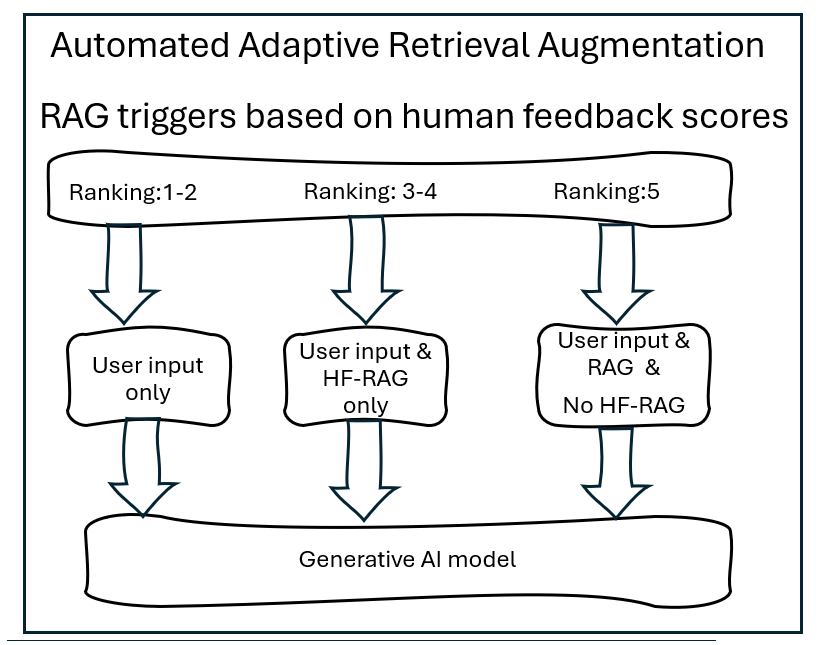

In [3]:
#@title show image
from IPython.display import Image, display

# Specify the path to your PNG file
image_path = '/content/rag_strategy.png'

# Display the image
# Display the image with specified width and height
display(Image(filename=image_path, width=500, height=400))  # Adjust the width and height as needed

## 2.2. Input

In [ ]:
# Request user input for keyword parsing
user_input = input("Enter your query: ").lower()

Enter your query: What is an LLM?


## 2.3 Mean ranking simulation scenario

Section *3.2.Human user ranking* illustrates a human user ranking function.

In this case, we are simulating a mean ranking of a system that a panel of users has been evaluating.

In [7]:
#Select a score between 1 and 5 to run the simulation
ranking=5

In [8]:
# initializing the text for the generative AI model simulations
text_input=[]

### Ranking 1-2 : No RAG

In [9]:
if ranking>=1 and ranking<3:
  text_input=user_input

### Ranking 3-4 : Human Expert Feedback RAG only

In [15]:
hf=False
if ranking>=3 and ranking<5:
  hf=True

Retrieve human expert feedback flashcards, documents or snippets

In [16]:
if hf==True:
  from grequests import download
  directory = "Chapter05"
  filename = "human_feedback.txt"
  download(directory, filename)

Downloaded 'human_feedback.txt' successfully.


Check if human_feedback.txt exists and retrieve content.

In this case, the content is customized for customer service.

In [ ]:
if hf==True:
  # Check if 'human_feedback.txt' exists
    efile = os.path.exists('human_feedback.txt')

    if efile:
        # Read and clean the file content
        with open('human_feedback.txt', 'r') as file:
            content = file.read().replace('\n', ' ').replace('#', '')  # Removing new line and markdown characters
            #print(content)  # Uncomment for debugging or maintenance display
        text_input=content
        print(text_input)
    else:
      print("File not found")
      hf=False

### Ranking 5 : RAG only with no HF

In [ ]:
if ranking>=5:
  max_words=100 #Limit: the size of the data we can add to the input
  rdata=process_query(user_input,max_words)
  print(rdata) # for maintenance if necessary
  if rdata:
        rdata_clean = rdata.replace('\n', ' ').replace('#', '')
        rdata_sentences = rdata_clean.split('. ')
  text_input=rdata
  print(text_input)

Fetching data from: https://en.wikipedia.org/wiki/Large_language_model

First 100 words of the cleaned text:
A large language model ( LLM ) is a computational model notable for its ability
to achieve general-purpose language generation and other natural language
processing tasks such as classification . Based on language models , LLMs
acquire these abilities by learning statistical relationships from vast amounts
of text during a computationally intensive self-supervised and semi-supervised
training process. [ 1 ] LLMs can be used for text generation, a form of
generative AI , by taking an input text and repeatedly predicting the next token
or word. [ 2 ] LLMs are artificial neural networks that use the transformer
architecture, invented

Prompt for Generator: Summarize the following information about llm: A large language model ( LLM ) is
a computational model notable for its ability to achieve general-purpose
language generation and other natural language processing tasks such as
cla

## 2.4. Checking the input before running the generator

In [ ]:
print("user input:",user_input)

user input: what is an llm?


In [ ]:
print("text input:",text_input)

text input: A large language model ( LLM ) is a computational model notable for its ability to achieve general-purpose language generation and other natural language processing tasks such as classification . Based on language models , LLMs acquire these abilities by learning statistical relationships from vast amounts of text during a computationally intensive self-supervised and semi-supervised training process. [ 1 ] LLMs can be used for text generation, a form of generative AI , by taking an input text and repeatedly predicting the next token or word. [ 2 ] LLMs are artificial neural networks that use the transformer architecture, invented


## 2.5.Installing the Generative AI environment

NOTE: Only run this section once. If you go back and modify the scenario in section 2.3., you can skip this section to run the generative AI model again. This installation is not at the top of this notebook because in production, a project team may choose to run this part of the program in another environment and even another server.

In [ ]:
!pip install openai==1.40.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.7/360.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00


In [ ]:
#API Key
#Store you key in a file and read it(you can type it directly in the notebook but it will be visible for somebody next to you)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
f = open("drive/MyDrive/files/api_key.txt", "r")
API_KEY=f.readline().strip()
f.close()

#The OpenAI Key
import os
import openai
os.environ['OPENAI_API_KEY'] =API_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

## 2.6.Content generation

In [ ]:
from openai import OpenAI
import time

client = OpenAI()
gptmodel="gpt-4o"
start_time = time.time()  # Start timing before the request

def call_gpt4_with_full_text(itext):
    # Join all lines to form a single string
    text_input = '\n'.join(itext)
    prompt = f"Please summarize or elaborate on the following content:\n{text_input}"

    try:
      response = client.chat.completions.create(
         model=gptmodel,
         messages=[
            {"role": "system", "content": "You are an expert Natural Language Processing exercise expert."},
            {"role": "assistant", "content": "1.You can explain read the input and answer in detail"},
            {"role": "user", "content": prompt}
         ],
         temperature=0.1  # Add the temperature parameter here and other parameters you need
        )
      return response.choices[0].message.content.strip()
    except Exception as e:
        return str(e)

# Call the function and print the result
gpt4_response = call_gpt4_with_full_text(text_input)

response_time = time.time() - start_time  # Measure response time
print(f"Response Time: {response_time:.2f} seconds")  # Print response time

print(gptmodel,"Response:", gpt4_response)

Response Time: 8.78 seconds
gpt-4o Response: ### Summary:
A large language model (LLM) is a computational model known for its ability to perform general-purpose language generation and other natural language processing tasks, such as classification. LLMs acquire these abilities by learning statistical relationships from vast amounts of text during a computationally intensive self-supervised and semi-supervised training process. They can be used for text generation, a form of generative AI, by taking input text and repeatedly predicting the next token or word. LLMs are artificial neural networks that use the transformer architecture.

### Elaboration:
A large language model (LLM) is a sophisticated type of artificial intelligence designed to understand and generate human language. These models are particularly notable for their versatility in handling a wide range of natural language processing (NLP) tasks. This includes generating coherent and contextually relevant text, classifying te

### Formatted response

In [ ]:
import textwrap

def print_formatted_response(response):
    # Define the width for wrapping the text
    wrapper = textwrap.TextWrapper(width=80)  # Set to 80 columns wide, but adjust as needed
    wrapped_text = wrapper.fill(text=response)

    # Print the formatted response with a header and footer
    print("GPT-4 Response:")
    print("---------------")
    print(wrapped_text)
    print("---------------\n")

# Assuming 'gpt4_response' contains the response from the previous GPT-4 call
print_formatted_response(gpt4_response)


GPT-4 Response:
---------------
### Summary: A large language model (LLM) is a computational model known for its
ability to perform general-purpose language generation and other natural
language processing tasks, such as classification. LLMs acquire these abilities
by learning statistical relationships from vast amounts of text during a
computationally intensive self-supervised and semi-supervised training process.
They can be used for text generation, a form of generative AI, by taking input
text and repeatedly predicting the next token or word. LLMs are artificial
neural networks that use the transformer architecture.  ### Elaboration: A large
language model (LLM) is a sophisticated type of artificial intelligence designed
to understand and generate human language. These models are particularly notable
for their versatility in handling a wide range of natural language processing
(NLP) tasks. This includes generating coherent and contextually relevant text,
classifying text into categ

# 3.EVALUATOR

## 3.1.Response time


In [ ]:
print(f"Response Time: {response_time:.2f} seconds")  # Print response time

Response Time: 8.78 seconds


## 3.2.Cosine Similarity Score

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(text1, text2):
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform([text1, text2])
    similarity = cosine_similarity(tfidf[0:1], tfidf[1:2])
    return similarity[0][0]

# Example usage with your existing functions
similarity_score = calculate_cosine_similarity(text_input, gpt4_response)

print(f"Cosine Similarity Score: {similarity_score:.3f}")

Cosine Similarity Score: 0.697


## 3.3.Human user rating



In [ ]:
# Score parameters
counter=20                      # number of queries
score_history=60                # human feedback
threshold=4                     # minimum rankings to trigger human expert feedback

In [ ]:
import numpy as np
def evaluate_response(response):
    print("\nGenerated Response:")
    print(response)
    print("\nPlease evaluate the response based on the following criteria:")
    print("1 - Poor, 2 - Fair, 3 - Good, 4 - Very Good, 5 - Excellent")
    score = input("Enter the relevance and coherence score (1-5): ")
    try:
        score = int(score)
        if 1 <= score <= 5:
            return score
        else:
            print("Invalid score. Please enter a number between 1 and 5.")
            return evaluate_response(response)  # Recursive call if the input is invalid
    except ValueError:
        print("Invalid input. Please enter a numerical value.")
        return evaluate_response(response)  # Recursive call if the input is invalid

score = evaluate_response(gpt4_response)
print("Evaluator Score:", score)

counter+=1
score_history+=score
mean_score=round(np.mean(score_history/counter), 2)
if counter>0:
  print("Rankings      :", counter)
  print("Score history : ", mean_score)


Generated Response:
### Summary:
A large language model (LLM) is a computational model known for its ability to perform general-purpose language generation and other natural language processing tasks, such as classification. LLMs acquire these abilities by learning statistical relationships from vast amounts of text during a computationally intensive self-supervised and semi-supervised training process. They can be used for text generation, a form of generative AI, by taking input text and repeatedly predicting the next token or word. LLMs are artificial neural networks that use the transformer architecture.

### Elaboration:
A large language model (LLM) is a sophisticated type of artificial intelligence designed to understand and generate human language. These models are particularly notable for their versatility in handling a wide range of natural language processing (NLP) tasks. This includes generating coherent and contextually relevant text, classifying text into categories, tran

## 3.4.Human expert evaluation

Human feedback for RAG adaptive loop preparation.

Flashcard creation.

images for the expert's interface

In [18]:
from grequests import download

# Define your variables
directory = "commons"
filename = "thumbs_up.png"
download(directory, filename)

# Define your variables
directory = "commons"
filename = "thumbs_down.png"
download(directory, filename)

Downloaded 'thumbs_up.png' successfully.
Downloaded 'thumbs_down.png' successfully.


defining thresholds

In [ ]:
counter_threshold=10
score_threshold=4

if counter>counter_threshold and score_history<=score_threshold:
  print("Human expert evaluation is required for the feedback loop.")

Let's use URI (Uniform Resource Identifier) to dispaly the icon images which is a string of characters that identifies a resource on the internet, either by location, name, or both.

Human Expert Adaptive RAG activated



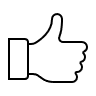
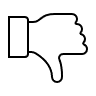

In [ ]:
import base64
from google.colab import output
from IPython.display import display, HTML

def image_to_data_uri(file_path):
    """
    Convert an image to a data URI.
    """
    with open(file_path, 'rb') as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode()
        return f'data:image/png;base64,{encoded_string}'

thumbs_up_data_uri = image_to_data_uri('/content/thumbs_up.png')
thumbs_down_data_uri = image_to_data_uri('/content/thumbs_down.png')

def display_icons():
    # Define the HTML content with the two clickable images
    html = f'''
    <img src="{thumbs_up_data_uri}" id="thumbs_up" style="cursor:pointer;" />
    <img src="{thumbs_down_data_uri}" id="thumbs_down" style="cursor:pointer;" />

    <script type="text/javascript">
        // Function to handle the click event on thumbs up
        document.querySelector("#thumbs_up").onclick = function() {{
            google.colab.output.clear();
            //Your function here
        }};
        // Function to handle the click event on thumbs down
        document.querySelector("#thumbs_down").onclick = function() {{
            const text = prompt("Please enter your feedback:");
            if (text !== null) {{
                google.colab.kernel.invokeFunction('notebook.save_feedback', [text], {{}});
            }}
        }};
    </script>
    '''
    display(HTML(html))

def save_feedback(feedback):
    with open('/content/expert_feedback.txt', 'w') as f:
        f.write(feedback)
    print("Feedback saved successfully.")

# Register the callback
output.register_callback('notebook.save_feedback', save_feedback)
print("Human Expert Adaptive RAG activated")

# Display the icons with click handlers
display_icons()

In [ ]:
# Check if 'human_feedback.txt' exists
expfile = os.path.exists('expert_feedback.txt')

if expfile:
    # Read and clean the file content
    with open('expert_feedback.txt', 'r') as file:
      content = file.read()
      print(content)